<h1>Imports</h1>

In [58]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
from IPython.display import clear_output
import ccxt
from datetime import datetime
from datetime import timedelta
from stocktrends import Renko


<h1>Init dataframe</h1>

In [59]:
# pairList = pairJson['hitbtc2018']
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2020-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)
df['date'] = df.index

print (df)

Successfully load 20045 candles for ETHUSDT
                        open     high      low    close       volume  \
timestamp                                                              
2020-01-01 00:00:00   129.16   129.19   128.68   128.87   7769.17336   
2020-01-01 01:00:00   128.87   130.65   128.78   130.64  11344.65516   
2020-01-01 02:00:00   130.63   130.98   130.35   130.85   7603.35623   
2020-01-01 03:00:00   130.85   130.89   129.94   130.20   4968.55433   
2020-01-01 04:00:00   130.21   130.74   130.15   130.20   3397.90747   
...                      ...      ...      ...      ...          ...   
2022-04-16 06:00:00  3041.77  3041.77  3035.29  3037.74   2878.67450   
2022-04-16 07:00:00  3037.74  3040.80  3033.27  3034.64   4736.45640   
2022-04-16 08:00:00  3034.64  3041.84  3027.71  3034.96   8344.50530   
2022-04-16 09:00:00  3034.96  3038.83  3031.51  3033.73   5104.73790   
2022-04-16 10:00:00  3033.74  3042.99  3032.69  3041.20   5018.88060   

                   

In [60]:
# Function to convert ohlc data into renko bricks. Pass dataframe name and brick size
def df_to_renko(data, n):
    data.reset_index(inplace=True)
    data.columns = [i.lower() for i in data.columns]
    df = Renko(data)
    df.brick_size = n
    renko_df = df.get_ohlc_data()
    return renko_df

In [61]:
# -- Intern parameter --
dfTest = df['2021-01-01':]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(rowRenko):
    if rowRenko['uptrend'] == True:
        return True
    else:
        return False 

def sellCondition(rowRenko):
    if rowRenko['uptrend'] == False:
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
previousRow = dfTest.iloc[0]
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    clear_output(wait=True)
    print(index)
    startRenko = datetime.strptime(str(index), '%Y-%m-%d %H:%M:%S') - timedelta(minutes=60000)
    dfComputeRenko = df[startRenko:index]
    dfRenko = df_to_renko(dfComputeRenko, row['close']*0.02)
    lastRowRenko = dfRenko.tail(1).squeeze()

    timeSince += 1
    # -- Buy market order --
    if buyCondition(lastRowRenko) and usd > 0:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(lastRowRenko):
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            wallet = usd

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0
    
    previousRow = row

print("Final wallet", wallet)
print(dfTrades)


2022-04-16 10:00:00
Final wallet 1398.8099593939207
                    date position             reason    price     frais  \
0    2021-01-01 00:00:00      Buy   Buy Market Order   734.07  0.700000   
1    2021-01-02 00:00:00     Sell  Sell Market Order   719.90  0.686007   
2    2021-01-02 01:00:00      Buy   Buy Market Order   729.38  0.685527   
3    2021-01-02 06:00:00     Sell  Sell Market Order   737.04  0.692241   
4    2021-01-02 08:00:00      Buy   Buy Market Order   733.84  0.691757   
...                  ...      ...                ...      ...       ...   
1190 2022-04-15 17:00:00      Buy   Buy Market Order  3031.34  0.980853   
1191 2022-04-15 19:00:00     Sell  Sell Market Order  3022.81  0.977408   
1192 2022-04-15 20:00:00      Buy   Buy Market Order  3030.69  0.976724   
1193 2022-04-16 04:00:00     Sell  Sell Market Order  3044.66  0.980539   
1194 2022-04-16 05:00:00      Buy   Buy Market Order  3041.76  0.979853   

             fiat     coins       wallet timeSi

In [62]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : ETH/USDT | Timeframe : 1h
Period : [2021-01-01 00:00:00] -> [2022-04-16 10:00:00]
Starting balance : 999.3000000000001 $

----- General Informations -----
Final balance : 1398.81 $
Performance vs US Dollar : 39.98 %
Buy and Hold Performence : 314.29 %
Performance vs Buy and Hold : -66.21 %
Best trade : +42.21 %, the 2021-01-04 07:00:00
Worst trade : -8.27 %, the 2021-05-19 23:00:00
Worst drawDown : - 65.58 %
Total fees :  1900.78 $

----- Trades Informations -----
Total trades on period : 597
Number of positive trades : 239
Number of negative trades :  358
Trades win rate ratio : 40.03 %
Average trades performance : 0.2 %
Average positive trades : 2.72 %
Average negative trades : -1.48 %

----- Time Informations -----
Average time duration for a trade : 11.41 periods
Maximum time duration for a trade : 251 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 7.46 periods
Maximum time duration between two trades : 115 periods
Min

----- 2021 Performances: 66.36% -----


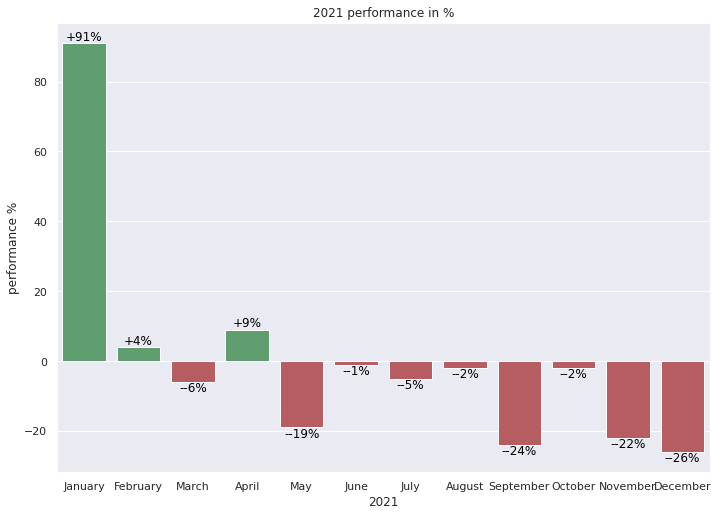

----- 2022 Performances: -15.8% -----


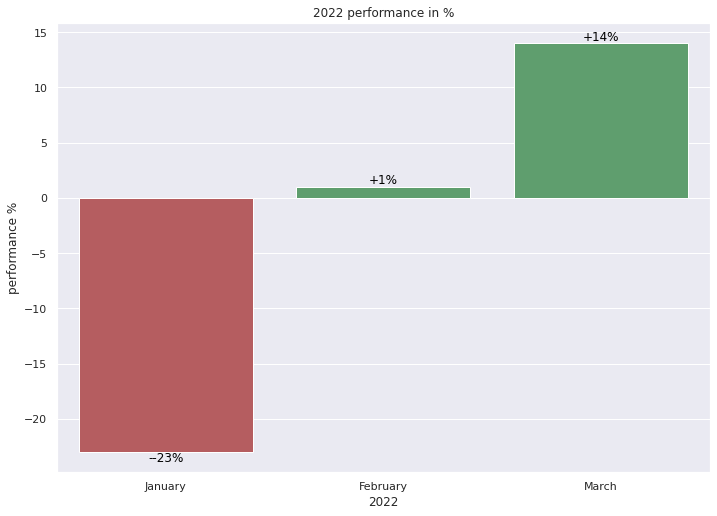

In [63]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


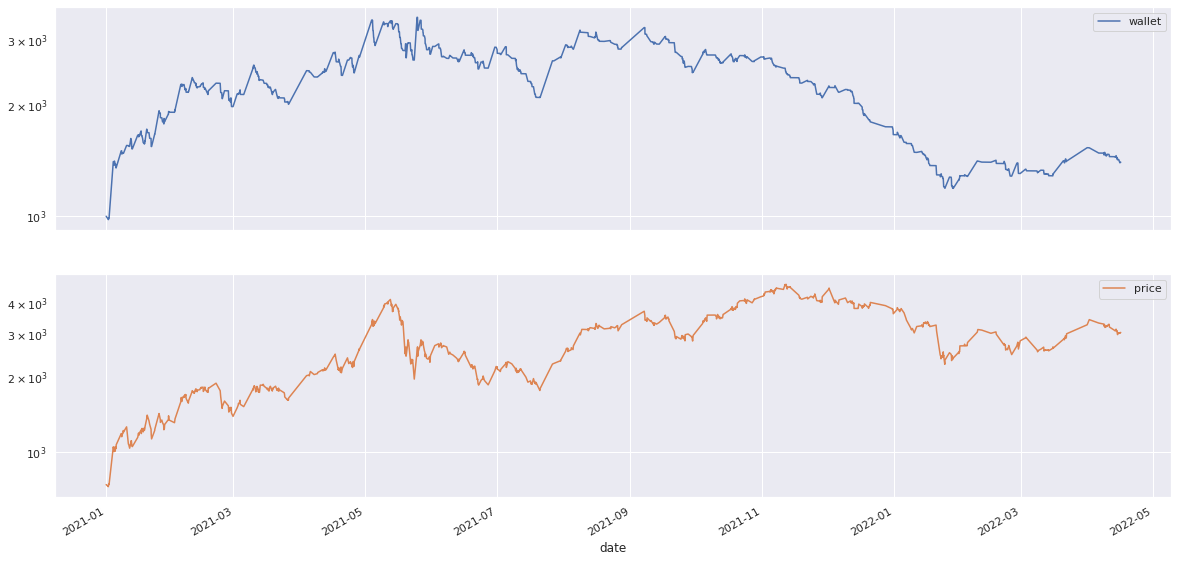

In [64]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)